<a href="https://www.kaggle.com/code/proxzima/skin-cancer-mnist-resnet50-iv3-vgg16-19-googlenet?scriptVersionId=105345653" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div align="center">
<font size="6"> Skin Cancer MNIST Classification (ResNet50, InceptionV3, VGG16, VGG19, GoogLeNet)  </font>  
</div> 

# 1. Convolutional Neural Network

<div align="center">
<font size="4"> Residual learning: a building block.  </font>  
</div> 

<img align="left" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/A-cell-from-the-Residual-Network-architecture-The-identity-connection-helps-to-reduce.png" width="350" style='margin-right:10px'/>
The degradation (of training accuracy) indicates that not all systems are similarly easy to optimize. In [Kaiming He et all. 2015] the degradation problem is adressed by introducing a deep residual learning framework. Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitly let these layers fit a residual mapping. Formally, denoting the desired underlying mapping as H(x), we let the stacked nonlinear layers fit another mapping of F(x) := H(x)−x. The original mapping is recast into F(x)+x. We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers. 

The formulation of F(x)+x can be realized by feedforward neural networks with ''shortcut connections'' (see scheme). Shortcut connections are those skipping one or
more layers. In our case, the shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers (see scheme). Identity shortcut connections add neither extra parameter nor computational complexity. The entire network can still be trained end-to-end by SGD with backpropagation, and can be easily implemented using common libraries

&nbsp;
&nbsp;

<div align="center">
<font size="4"> Example of ResNet50 vs Xception vs Inception-V3 vs VGG-19 vs VGG-16 as reference model.  </font>  
<img align="center" src="https://github.com/PROxZIMA/Skin-Cancer-MNIST-HAM10000/raw/master/assets/ResNet50%20vs%20Xception%20vs%20Inception-V3%20vs%20VGG-19%20vs%20VGG-16.png" width="870" />
</div>

&nbsp;
&nbsp;

<div align="center">
<font size="4"> Detailed example of GoogLeNet a.k.a. Inception-V1 (Szegedy, 2015) as reference model.  </font>  
<img align="center" src="https://github.com/PROxZIMA/Skin-Cancer-MNIST-HAM10000/raw/master/assets/GoogLeNet%20(Inception-V1).png" />
</div> 

# 2. Libraries

# 2.1 Load Required Libraries

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# os.environ['TF_CPP_MIN_LOG_LEVEL'] 에 입력될 수 있는 값은 아래와 같습니다.
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import re
import gc
import sys
import glob
import pathlib
# path 경로에서 폴더 있는지 없는지 확인해줌 말고도 기능 많음
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob
# 파일명을 리스트 형식으로 반환

import cv2

import PIL
from PIL import Image
# 이미지 컷팅

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter
# =value_counts

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

# 2.2 Load TensorFlow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, Dropout, BatchNormalization,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from keras.layers.merging import concatenate

from tensorflow.python.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# Callback : 특정 이벤트가 발생할 때마다 Tensorflow는 개발자가 등록해 둔 Callback 함수들을 호출
# EalryStopping : 일정 성능이 나지 않으면 멈추기

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
# model.summary 시각화 **중요

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

tf.get_logger().setLevel('ERROR')

In [3]:
CFG = dict(
    batch_size            =  20,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
    epochs                =  30,   # 5; 10; 20;
    last_trainable_layers =   0,
    verbose               =   1,   # 0; 1
    fontsize              =  14,

    # Images sizes
    img_width             = 512,   # 600 Original -> 150
    img_height            = 512,   # 450 Original -> 112

    # Images augs
    ROTATION_RANGE        =  90.0,
    ZOOM_RANGE            =   0.1,
    HSHIFT_RANGE          =   0.1,
    WSHIFT_RANGE          =   0.1,
    HFLIP                 = False,
    VFLIP                 = False,

    # Postprocessing
    stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
    run_functions_eagerly = False,

    SEED = 41
)
# CFG = {
#     'IMG_SIZE':512,
#     'EPOCHS':5,
#     'LEARNING_RATE':1e-4,
#     'BATCH_SIZE':16,
#     'SEED':41
# }

# 4. Paths

In [8]:
!pwd

/Users/alexkim/Library/CloudStorage/GoogleDrive-amdtheg@gmail.com/내 드라이브/Colab Notebooks_TeamShare/open


In [7]:
%cd /Users/alexkim/Library/CloudStorage/GoogleDrive-amdtheg@gmail.com/내 드라이브/Colab Notebooks_TeamShare/open

/Users/alexkim/Library/CloudStorage/GoogleDrive-amdtheg@gmail.com/내 드라이브/Colab Notebooks_TeamShare/open


In [9]:
# base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names

# base_skin_dir = '/Users/sylee/Desktop/프로젝트/open'
device = torch.device('mps:0') if torch.backends.mps.is_available() else torch.device('cpu')
device
#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}

device(type='mps', index=0)

# 5. Dataset
# 5.1 Description

The data set contains the following diseases:  
- Actinic Keratosis
- Basal Cell Carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented Benign Keratosis
- Vascular Lesion

In [8]:
# df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# df = pd.read_pickle(f"../input/skin-cancer-mnist-ham10000-pickle/HAM10000_metadata-h{CFG['img_height']}-w{CFG['img_width']}.pkl")
# df.head()

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df[:5]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [12]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [13]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )

In [14]:
val_df, test_df, val_labels, test_labels = train_test_split(
                                                    val_df, 
                                                    val_labels, 
                                                    test_size=0.5, 
                                                    random_state=CFG['SEED']
                                                )

In [18]:
train_df.shape

(800, 27)

In [17]:
val_df.shape,test_df.shape

((100, 27), (100, 27))

In [19]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

In [20]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        img_path = self.medical_df['img_path'].iloc[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [21]:
# # Given lesion types
# classes = df.dx.unique()
num_classes = 2
# classes, num_classes

In [18]:
#Lesion Dictionary created for ease
# lesion_type_dict = {
#     'bkl'  : 'Pigmented Benign keratosis',
#     'nv'   : 'Melanocytic nevi', # nevus
#     'df'   : 'Dermatofibroma',
#     'mel'  : 'Melanoma',
#     'vasc' : 'Vascular lesions',
#     'bcc'  : 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
# }

In [19]:

# Not required for pickled data
# Creating New Columns for better readability

# df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")
# df['path'] = df.image_id.map(imageid_path_dict.get)
# df['cell_type'] = df.dx.map(lesion_type_dict.get) 
# df['cell_type_idx'] = pd.Categorical(df.dx).codes
# df.sample(5)

# 5.2 Exploratory Data Analysis x 안함

In [22]:
# df.shape

In [ ]:
# df.isnull().sum()

In [ ]:
# df.age.fillna((df.age.mean()), inplace=True)
# df.isnull().sum()

# 6. Keras image data processing

In [21]:
# Not required for pickled data
# df['image'] = df.path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))
# df.to_pickle(f"HAM10000_metadata-h{CFG['img_height']}-w{CFG['img_width']}.pkl", compression='infer', protocol=4)

In [30]:
train_df['image'] = train_df.img_path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))
test_df['image'] = test_df.img_path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))
val_df['image'] = val_df.img_path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))

OSError: [Errno 89] Operation canceled

In [23]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
val_df.to_pickle('val_df.pkl')

In [24]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')
val_df = pd.read_pickle('val_df.pkl')

In [27]:
train_df

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
976,BC_01_3277,./train_imgs/BC_01_3277.png,-,-2.522114,2010-02-05,0,1,0,-0.793655,3,...,1,0.017689,1,-0.367095,-0.784134,0,0,0,-0.25997,0
668,BC_01_2734,./train_imgs/BC_01_2734.png,-,-1.208969,2011-10-13,3,0,0,-0.881586,1,...,1,0.619883,1,1.237691,-0.784134,1,2,0,-0.25997,0
836,BC_01_2962,./train_imgs/BC_01_2962.png,-,-0.596168,2007-11-13,0,1,0,-0.617792,0,...,1,-1.487795,1,-0.902024,-0.784134,0,0,0,-0.25997,0
479,BC_01_2228,./train_imgs/BC_01_2228.png,-,0.716977,2013-12-09,0,2,0,-1.233311,1,...,1,0.920980,1,0.435298,-0.512041,1,2,0,-0.25997,0
83,BC_01_0405,./train_imgs/BC_01_0405.png,-,-0.946340,2020-05-07,0,0,1,-0.705724,2,...,1,0.318786,1,0.167834,0.938215,0,0,0,-0.25997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,BC_01_0397,./train_imgs/BC_01_0397.png,./train_masks/BC_01_0397.png,0.541891,2020-01-08,0,1,0,0.437383,2,...,1,0.619883,1,0.702763,0.316210,0,0,0,-0.25997,0
994,BC_01_3447,./train_imgs/BC_01_3447.png,-,-0.946340,2009-01-16,0,1,0,-0.705724,1,...,0,-1.487795,0,-0.902024,-0.784134,0,1,0,-0.25997,0
908,BC_01_3056,./train_imgs/BC_01_3056.png,-,0.541891,2007-03-02,0,1,0,0.613245,2,...,1,-1.487795,1,-0.902024,-0.784134,0,0,0,-0.25997,0
931,BC_01_3083,./train_imgs/BC_01_3083.png,-,0.804520,2007-01-16,0,1,0,1.228764,2,...,1,-1.487795,1,-0.902024,-0.784134,0,0,0,-0.25997,0


In [25]:
def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images


trainimages = prepareimages(list(train_df.image))
testimages = prepareimages(list(test_df.image))
validationimages = prepareimages(list(val_df.image))
trainlabels = np.asarray(train_labels)
testlabels = np.asarray(test_labels)
validationlabels = np.asarray(val_labels)

AttributeError: 'DataFrame' object has no attribute 'image'

In [26]:
image_shape = (CFG['img_height'], CFG['img_width'], 3)

trainimages = trainimages.reshape(trainimages.shape[0], *image_shape)

data_gen = ImageDataGenerator(
    rotation_range = CFG['ROTATION_RANGE'],    # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = CFG['ZOOM_RANGE'],            # Randomly zoom image 
    width_shift_range = CFG['WSHIFT_RANGE'],   # randomly shift images horizontally
    height_shift_range = CFG['HSHIFT_RANGE'],  # randomly shift images vertically
    horizontal_flip=CFG['HFLIP'],              # randomly flip images
    vertical_flip=CFG['VFLIP']                 # randomly flip images
)
data_gen.fit(trainimages)

# 7. Model

# 7.1 Build the model

In [27]:
def build_model(
    base_model,
    base_model_name,
    model_optimizer,
    raw_model = False,
    last_trainable_layers = CFG['last_trainable_layers'],
    model_loss = 'sparse_categorical_crossentropy'
):
    print(f'Building {base_model_name} model...')

    # We reduce significantly number of trainable parameters by freezing certain layers,
    # excluding from training, i.e. their weights will never be updated
    for layer in base_model.layers:
        layer.trainable = False

    if 0 < last_trainable_layers < len(base_model.layers):
        for layer in base_model.layers[-last_trainable_layers:]:
            layer.trainable = True

    if raw_model == True:
        model = base_model
    else:
        model = Sequential([
            base_model,

            Dropout(0.5),
            Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.02)),

            Dropout(0.5),
            Dense(num_classes, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02)) # num classes = 9
        ])

    model.compile(
        optimizer = model_optimizer,
      # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
        loss = model_loss,
        metrics=['accuracy']
    )
    
    return model

# 7.2 Visualize model

In [28]:
def visualize_model(model, model_name):
    print(model.summary())
    return plot_model(model, to_file=f'{model_name}_plot.png', show_shapes=True, show_layer_names=True)

# 8. Fit model

In [29]:
class GCCollectCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [30]:
def fit_model(
    model,
    model_name,
    trainimages,
    trainlabels,
    validationimages,
    validationlabels,
    early_stopper_patience = CFG['stopper_patience'],
    epochs = CFG['epochs'],
    batch_size = CFG['batch_size']
):
    # tf.function - decorated function tried to create variables on non-first call'. 
    tf.config.run_functions_eagerly(CFG['run_functions_eagerly']) # otherwise error

    print(f'Fitting {model_name} model...')
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stopper_patience)
    cb_checkpointer  = ModelCheckpoint(
        filepath=f'model/{model_name}.hdf5',
      # filepath = CFG['path_model']+'ResNet50-{epoch:02d}-{val_loss:.2f}.hdf5',
        monitor  = 'val_loss',
        save_best_only=True, 
        mode='min'
    )

    callbacks_list = [cb_checkpointer, cb_early_stopper]

    history = model.fit(
        data_gen.flow(trainimages, trainlabels, batch_size = batch_size),
        epochs = epochs,
        validation_data = data_gen.flow(validationimages, validationlabels, batch_size = batch_size),
        verbose = CFG['verbose'],
        steps_per_epoch=trainimages.shape[0] // batch_size,                   
        callbacks=[cb_checkpointer, cb_early_stopper] # We can add GCCollectCallback() to save memory
    )

    return history

# 9. Visualize performance

In [31]:
def visualize_performance(model_name, history, fontsize = CFG['fontsize']):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    metrics = history.history['accuracy']
    epochs_range = range(1, len(metrics) + 1) 

    plt.figure(figsize=(23, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.suptitle(f'Accuracy & Loss for {model_name} model', fontsize=fontsize)
    plt.show()

# 10. Evaluate on test

In [32]:
def evaluate_model(
    model_name,
    trainimages,
    trainlabels,
    validationimages,
    validationlabels,
    testimages,
    testlabels
):
    print(f'Evaluating {model_name} model...\n')
    model = load_model(f'./model/{model_name}.hdf5') # Loads the best fit model

    print("Train loss = {}  ;  Train accuracy = {:.2%}\n".format(*model.evaluate(trainimages, trainlabels, verbose = CFG['verbose'])))

    print("Validation loss = {}  ;  Validation accuracy = {:.2%}\n".format(*model.evaluate(validationimages, validationlabels, verbose = CFG['verbose'])))

    test_loss, test_acc = model.evaluate(testimages, testlabels, verbose = CFG['verbose'])
    print(f"Test loss = {test_loss}  ;  Test accuracy = {test_acc:.2%}")

    return (model, test_loss, test_acc)

In [33]:
def computing_prediction(model, model_name, trainimages, testimages):
    print(f'Computing predictions for {model_name}...')
    train_pred = model.predict(trainimages)
    train_pred_classes = np.argmax(train_pred,axis = 1)
    test_pred = model.predict(testimages)
    # Convert predictions classes to one hot vectors
    test_pred_classes = np.argmax(test_pred,axis = 1)

    return train_pred, train_pred_classes, test_pred, test_pred_classes

# 11. Compare test_pred with Ground Truth (train_pred)

In [34]:
def model_report(
    model_name,
    trainlabels,
    train_pred_classes,
    testlabels,
    test_pred_classes,
    lesion_type_dict,
    fontsize = CFG['fontsize']
):
    print(f'Model report for {model_name} model ->\n\n')
    print("Train Report :\n", classification_report(trainlabels, train_pred_classes, target_names=lesion_type_dict.values()))
    print("Test Report :\n", classification_report(testlabels, test_pred_classes, target_names=lesion_type_dict.values()))

    cm = confusion_matrix(testlabels, test_pred_classes)

    fig = plt.figure(figsize=(12, 8))
    df_cm = pd.DataFrame(cm, index=lesion_type_dict.values(), columns=lesion_type_dict.values())

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.title(f'Confusion Matrix for Multiclass Classifcation ({model_name})', fontsize=fontsize)
    plt.show()

# 12. ResNet50 model

In [35]:
ResNet50_name = 'ResNet50'

In [36]:
resnet50 = ResNet50(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

Resnet50_model = build_model(
    base_model = resnet50,
    base_model_name = ResNet50_name,
    model_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
)

Metal device set to: Apple M1 Pro
Building ResNet50 model...


In [37]:
visualize_model(model = Resnet50_model, model_name = ResNet50_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None
You must install pydot (`pip inst

In [38]:
history = fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

Fitting ResNet50 model...
Epoch 1/5
40/40 [==============================] - 27s 628ms/step - loss: 4.2082 - accuracy: 0.5275 - val_loss: 2.6629 - val_accuracy: 0.5700
Epoch 2/5
40/40 [==============================] - 24s 592ms/step - loss: 2.2372 - accuracy: 0.5950 - val_loss: 1.7917 - val_accuracy: 0.7400
Epoch 3/5
40/40 [==============================] - 24s 591ms/step - loss: 1.6045 - accuracy: 0.6312 - val_loss: 1.4157 - val_accuracy: 0.6800
Epoch 4/5
40/40 [==============================] - 24s 591ms/step - loss: 1.3423 - accuracy: 0.6225 - val_loss: 1.2304 - val_accuracy: 0.5800
Epoch 5/5
40/40 [==============================] - 25s 605ms/step - loss: 1.1882 - accuracy: 0.5900 - val_loss: 1.0694 - val_accuracy: 0.6700


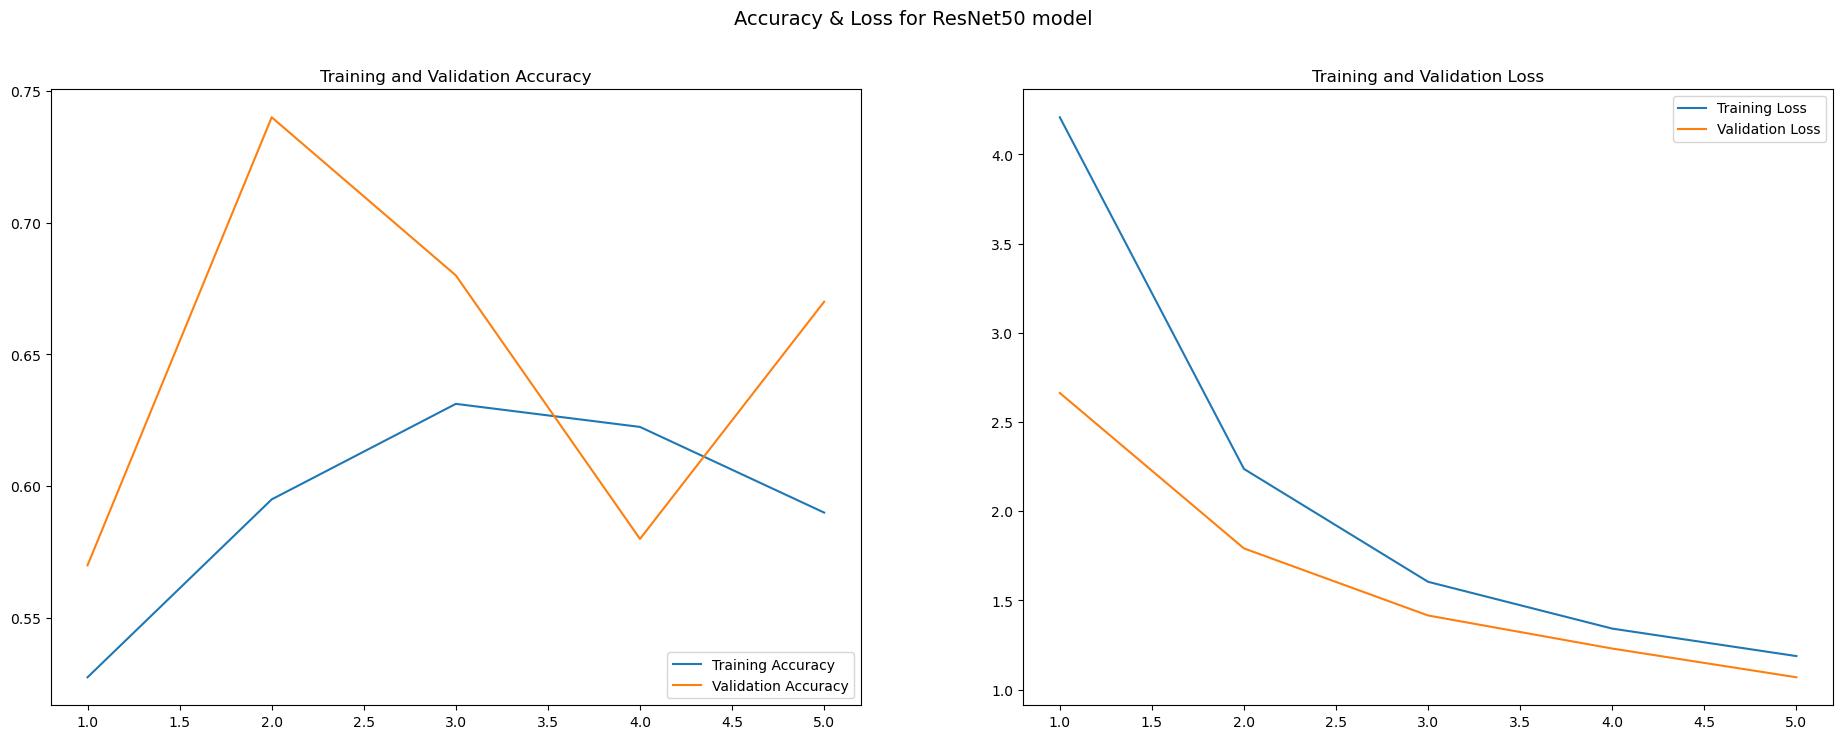

In [39]:
visualize_performance(
    model_name = ResNet50_name,
    history = history
)

In [40]:
Resnet50_model, test_loss, ResNet50_test_acc = evaluate_model(
    model_name = ResNet50_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

Evaluating ResNet50 model...

25/25 [==============================] - 18s 683ms/step - loss: 1.0722 - accuracy: 0.6925
Train loss = 1.0722068548202515  ;  Train accuracy = 69.25%

4/4 [==============================] - 3s 662ms/step - loss: 1.0861 - accuracy: 0.7000
Validation loss = 1.0860601663589478  ;  Validation accuracy = 70.00%

4/4 [==============================] - 3s 546ms/step - loss: 1.0866 - accuracy: 0.6300
Test loss = 1.0865826606750488  ;  Test accuracy = 63.00%


In [41]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

Computing predictions for ResNet50...
4/4 [==============================] - 4s 942ms/step


(array([[0.6272725 , 0.64484805],
        [0.6927588 , 0.56968474],
        [0.6573548 , 0.65745276],
        [0.6327333 , 0.49313736],
        [0.6238856 , 0.6150365 ],
        [0.6415959 , 0.5821882 ],
        [0.6422933 , 0.6047316 ],
        [0.68859655, 0.57904136],
        [0.6792793 , 0.749807  ],
        [0.6725374 , 0.6895293 ],
        [0.67790645, 0.6379881 ],
        [0.6248287 , 0.7452787 ],
        [0.5780132 , 0.63118684],
        [0.6214073 , 0.610325  ],
        [0.6332834 , 0.5132265 ],
        [0.6890859 , 0.61130404],
        [0.6950412 , 0.7987511 ],
        [0.62181985, 0.5168632 ],
        [0.6543122 , 0.60411745],
        [0.6385578 , 0.6100391 ],
        [0.68168384, 0.8108308 ],
        [0.62984425, 0.65539134],
        [0.63731784, 0.6369209 ],
        [0.6113916 , 0.54928243],
        [0.6610088 , 0.6584303 ],
        [0.6839069 , 0.5782637 ],
        [0.61801106, 0.66656965],
        [0.6114459 , 0.58418655],
        [0.6438291 , 0.5551908 ],
        [0.620

In [43]:
model_report(
    model_name = ResNet50_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
#     lesion_type_dict = lesion_type_dict
)

TypeError: model_report() missing 1 required positional argument: 'lesion_type_dict'

# 13. InceptionV3 model

In [44]:
InceptionV3_name = 'InceptionV3'

In [46]:
inceptionv3 = InceptionV3(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

InceptionV3_model = build_model(
    base_model = inceptionv3,
    base_model_name = InceptionV3_name,
    model_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
)

Building InceptionV3 model...


In [47]:
visualize_model(model = InceptionV3_model, model_name = InceptionV3_name)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 22,065,314
Trainable params: 262,530
Non-trainable params: 21,802,784
_________________________________________________________________
None
You must install pydot (`pip in

In [48]:
history = fit_model(    
    model = InceptionV3_model,
    model_name = InceptionV3_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

Fitting InceptionV3 model...
Epoch 1/5
40/40 [==============================] - 29s 636ms/step - loss: 6.8675 - accuracy: 0.5225 - val_loss: 4.6618 - val_accuracy: 0.4600
Epoch 2/5
40/40 [==============================] - 24s 606ms/step - loss: 4.0073 - accuracy: 0.5238 - val_loss: 3.1814 - val_accuracy: 0.4400
Epoch 3/5
40/40 [==============================] - 25s 606ms/step - loss: 2.9487 - accuracy: 0.5387 - val_loss: 2.4880 - val_accuracy: 0.4700
Epoch 4/5
40/40 [==============================] - 25s 609ms/step - loss: 2.3580 - accuracy: 0.5225 - val_loss: 2.1460 - val_accuracy: 0.4800
Epoch 5/5
40/40 [==============================] - 25s 630ms/step - loss: 2.0510 - accuracy: 0.5150 - val_loss: 1.9012 - val_accuracy: 0.5700


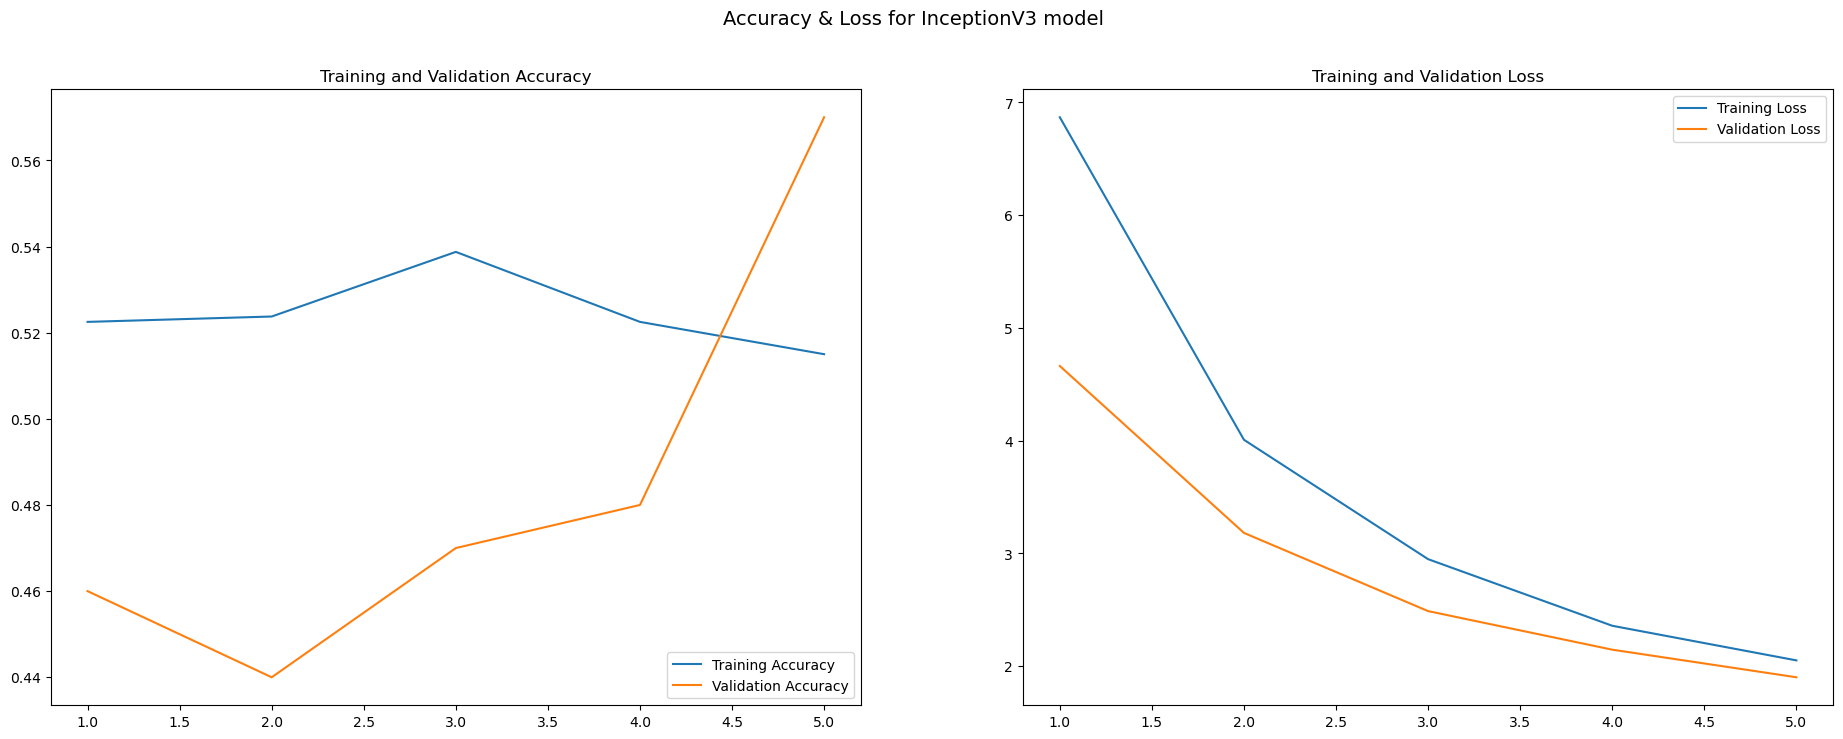

In [49]:
visualize_performance(
    model_name = InceptionV3_name,
    history = history
)

In [50]:
InceptionV3_model, test_loss, InceptionV3_test_acc = evaluate_model(
    model_name = InceptionV3_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

Evaluating InceptionV3 model...

25/25 [==============================] - 16s 583ms/step - loss: 1.8973 - accuracy: 0.6550
Train loss = 1.89728844165802  ;  Train accuracy = 65.50%

4/4 [==============================] - 3s 656ms/step - loss: 1.8969 - accuracy: 0.6900
Validation loss = 1.8969002962112427  ;  Validation accuracy = 69.00%

4/4 [==============================] - 2s 437ms/step - loss: 1.9004 - accuracy: 0.6900
Test loss = 1.9003844261169434  ;  Test accuracy = 69.00%


In [51]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = InceptionV3_model,
    model_name = InceptionV3_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

Computing predictions for InceptionV3...
4/4 [==============================] - 3s 665ms/step


(array([[0.56774265, 0.578573  ],
        [0.5111639 , 0.51351666],
        [0.5052676 , 0.508716  ],
        [0.424528  , 0.42168975],
        [0.38659838, 0.38336685],
        [0.50095934, 0.49904072],
        [0.413622  , 0.40907004],
        [0.38852546, 0.3853126 ],
        [0.56433386, 0.5758492 ],
        [0.48113626, 0.48876458],
        [0.44335648, 0.4407312 ],
        [0.69700253, 0.7152794 ],
        [0.6077873 , 0.63321894],
        [0.4661002 , 0.4710188 ],
        [0.4372149 , 0.42798898],
        [0.43917924, 0.4365058 ],
        [0.49049464, 0.4919251 ],
        [0.48465398, 0.48252836],
        [0.3795672 , 0.37626877],
        [0.50359696, 0.50623417],
        [0.53341544, 0.54012275],
        [0.6741107 , 0.69039804],
        [0.58596295, 0.5930148 ],
        [0.41345018, 0.4104918 ],
        [0.56312853, 0.5701725 ],
        [0.5264526 , 0.5301842 ],
        [0.45585728, 0.45337898],
        [0.49817446, 0.49622017],
        [0.43458608, 0.4368607 ],
        [0.451

In [ ]:
model_report(
    model_name = InceptionV3_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 14. VGG-16 model

In [52]:
VGG16_name = 'VGG-16'

In [54]:
vgg16 = VGG16(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

VGG16_model = build_model(
    base_model = vgg16,
    base_model_name = VGG16_name,
    model_optimizer = RMSprop(lr=0.001, epsilon=None, decay=1e-6)
)

Building VGG-16 model...


In [55]:
visualize_model(model = VGG16_model, model_name = VGG16_name)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________
None
You must install pydot (`pip ins

In [56]:
history = fit_model(    
    model = VGG16_model,
    model_name = VGG16_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

Fitting VGG-16 model...
Epoch 1/5
40/40 [==============================] - 44s 1s/step - loss: 4.1983 - accuracy: 0.5625 - val_loss: 2.8779 - val_accuracy: 0.6500
Epoch 2/5
40/40 [==============================] - 42s 1s/step - loss: 2.7939 - accuracy: 0.5850 - val_loss: 2.1718 - val_accuracy: 0.6400
Epoch 3/5
40/40 [==============================] - 42s 1s/step - loss: 2.0884 - accuracy: 0.6287 - val_loss: 1.8200 - val_accuracy: 0.6200
Epoch 4/5
40/40 [==============================] - 42s 1s/step - loss: 1.7312 - accuracy: 0.6037 - val_loss: 1.5816 - val_accuracy: 0.6400
Epoch 5/5
40/40 [==============================] - 42s 1s/step - loss: 1.5507 - accuracy: 0.5950 - val_loss: 1.2726 - val_accuracy: 0.6700


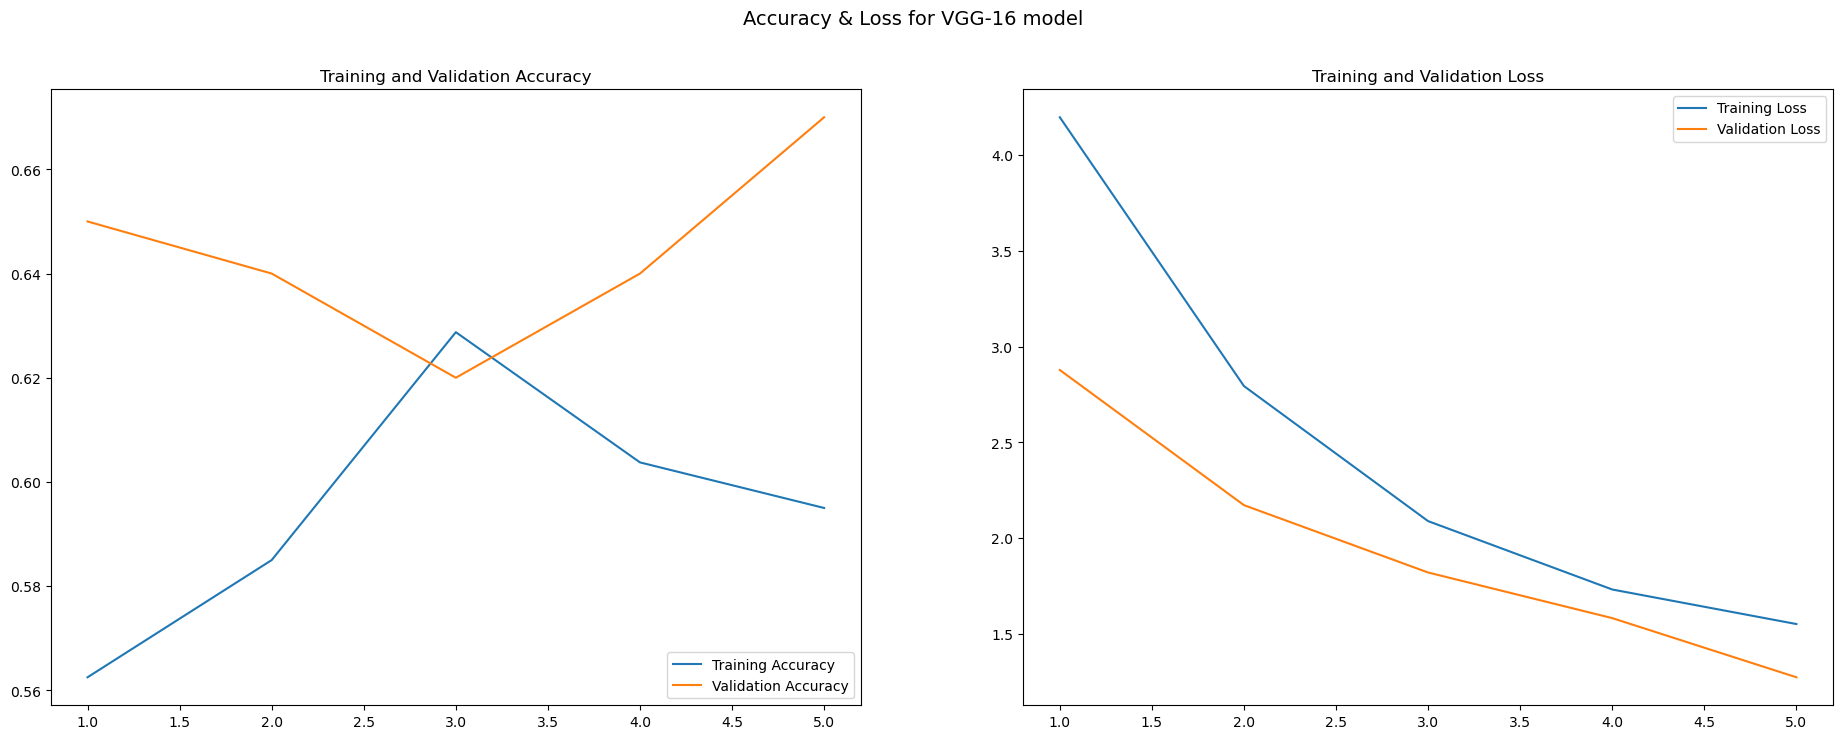

In [57]:
visualize_performance(
    model_name = VGG16_name,
    history = history
)

In [ ]:
VGG16_model, test_loss, VGG16_test_acc = evaluate_model(
    model_name = VGG16_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

Evaluating VGG-16 model...



In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = VGG16_model,
    model_name = VGG16_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = VGG16_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 15. VGG-19 model

In [ ]:
VGG19_name = 'VGG-19'

In [ ]:
vgg19 = VGG19(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

VGG19_model = build_model(
    base_model = vgg19,
    base_model_name = VGG19_name,
    model_optimizer = RMSprop(lr=0.0001, epsilon=None, decay=1e-6)
)

In [ ]:
visualize_model(model = VGG19_model, model_name = VGG19_name)

In [ ]:
history = fit_model(    
    model = VGG19_model,
    model_name = VGG19_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = VGG19_name,
    history = history
)

In [ ]:
VGG19_model, test_loss, VGG19_test_acc = evaluate_model(
    model_name = VGG19_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = VGG19_model,
    model_name = VGG19_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = VGG19_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 16. GoogLeNet model

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer


In [ ]:
def GoogLeNet(input_shape, num_classes):
    # input layer 
    input_layer = Input(shape = input_shape)

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    # X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    # X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    # X1 = Flatten()(X1)
    # X1 = Dense(1024, activation = 'relu')(X1)
    # X1 = Dropout(0.7)(X1)
    # X1 = Dense(num_classes, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    # X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    # X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    # X2 = Flatten()(X2)
    # X2 = Dense(1024, activation = 'relu')(X2)
    # X2 = Dropout(0.7)(X2)
    # X2 = Dense(num_classes, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(num_classes, activation = 'softmax', name='output')(X)

    # model
    # model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [ ]:
GoogLeNet_name = 'GoogLeNet'

In [ ]:
googlenet = GoogLeNet(
    input_shape=image_shape,
    num_classes=num_classes
)

GoogLeNet_model = build_model(
    base_model = googlenet,
    base_model_name = GoogLeNet_name,
    model_optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
    raw_model = True
)

In [ ]:
visualize_model(model = GoogLeNet_model, model_name = GoogLeNet_name)

In [ ]:
history = fit_model(    
    model = GoogLeNet_model,
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = GoogLeNet_name,
    history = history
)

In [ ]:
GoogLeNet_model, test_loss, GoogLeNet_test_acc = evaluate_model(
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = GoogLeNet_model,
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = GoogLeNet_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 17. Summary

In [1]:
import pandas as pd
pd.DataFrame.from_dict(
    dict(
        Model    = [ResNet50_name,     InceptionV3_name,     VGG16_name],#,     VGG19_name,     GoogLeNet_name],
        Accuracy = [ResNet50_test_acc, InceptionV3_test_acc, VGG16_test_acc],#, VGG19_test_acc, GoogLeNet_test_acc],
    )
).style.hide_index()

NameError: name 'pd' is not defined

# 18. References


- [Article] [Kaiming He et al Deep Residual Learning for Image Recognition. (CVPR 2015)](https://arxiv.org/abs/1512.03385)
- [Image] [A Basic Residual Block](https://medium.datadriveninvestor.com/developing-with-keras-functional-api-6017828408cd)
- [Image] [Deep Feature-Based Classifiers for Fruit Fly Identification (Diptera: Tephritidae)](https://www.researchgate.net/figure/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures_fig1_330478807)
- [Image] [Googlenet/InceptionV1 architecture](https://developer.ridgerun.com/wiki/index.php?title=GstInference/Supported_architectures/InceptionV2)
- [Notebook] [skin cancer resnet50](https://www.kaggle.com/code/zhyaqi/skin-cancer-resnet50)
- [Notebook] [MinorProject_skinLesions](https://www.kaggle.com/code/nancybhargava/minorproject-skinlesions)